In [16]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go

# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))
from configs.path_config import EXTRACTED_DATA_DIR, OUTPUT_DIR

from src.clustering import clustering_preprocess #load_data, drop_columns_by_header_rules, remove_outliers, explain_variance, do_pca
from src.clustering import clustering_models # kmeans_clustering, gmm_clustering, kl_divergence, jeffreys_divergence, merge_clusters_by_divergence, streaming_dpgmm_clustering
from src.clustering import clustering_visualization #plot_clusters_over_time, plot_cluster_mean_and_std

### Data loading and preprocessing


In [17]:
path = EXTRACTED_DATA_DIR / 'strain_distributions' / 'alvbrodel_04' / 'S-B_Close_Comp_20091129120000_20210611160000_strain_distribution_04 1.csv'
# path = OUTPUT_DIR / 'strain_distributions' / 'N-F_Mid_Comp_20091129120000_20210611160000_strain_distribution.csv'
df = clustering_preprocess.load_data(path)
# df

In [18]:
df = clustering_preprocess.drop_columns_by_header_rules(df, threshold=0)
# df

In [19]:
df_strain, df = clustering_preprocess.remove_outliers(df, threshold=7, individual_threshold=7)
# df

Total number of outliers removed: 323


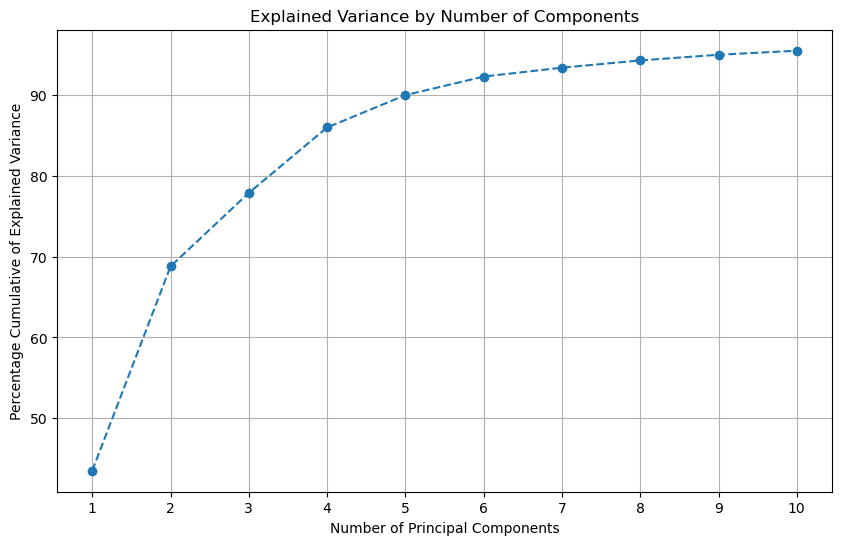

In [20]:
clustering_preprocess.explain_variance(df_strain)

In [21]:
n_components = 8
normalized_pca_components, df_pca = clustering_preprocess.do_pca(n_components, df_strain, df)

### GMM Clustering

c:\Users\gwd007\Documents\Exjobb\src\clustering\clustering_models.py:108: UserWarning:

Mismatched number of handles and labels: len(handles) = 7 len(labels) = 10



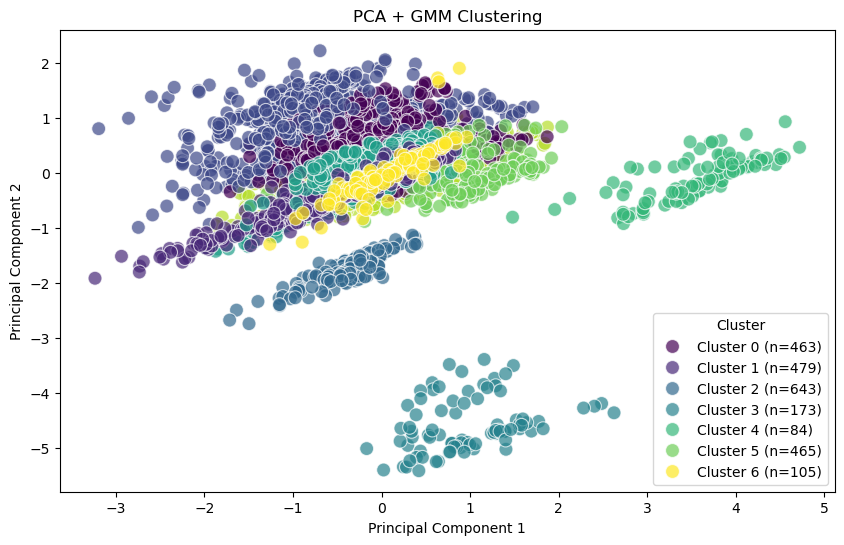

In [22]:
n_clusters = 10
data_with_gmm = clustering_models.gmm_clustering(normalized_pca_components, df, n_clusters)
# data_with_gmm

In [23]:
clustering_visualization.plot_clusters_over_time(data_with_gmm, 'GMM')

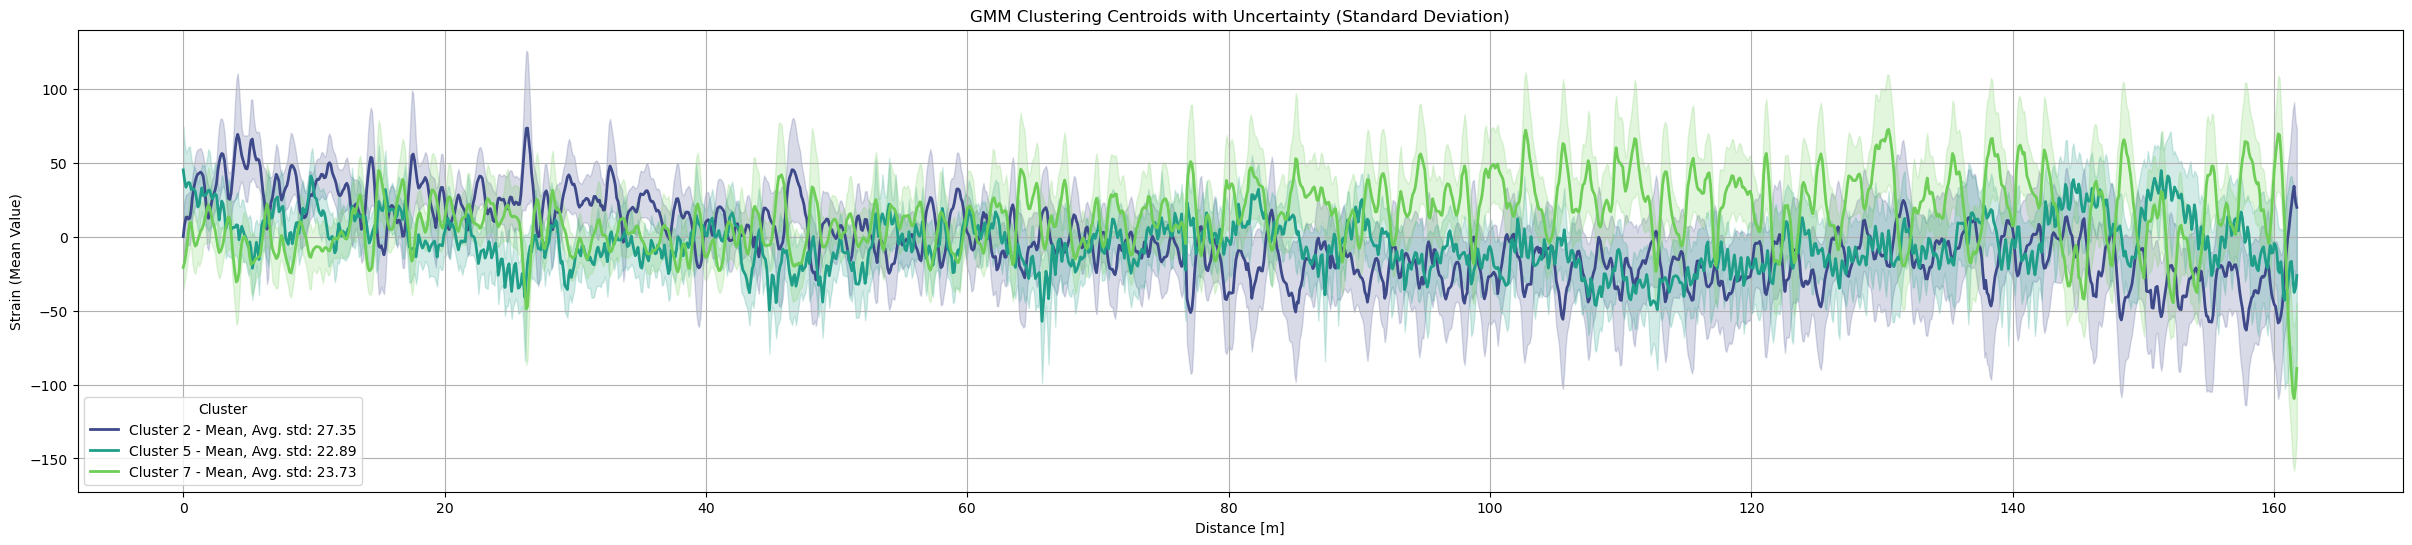

In [24]:
clusters_to_keep = [2, 5, 7] # 'all' or a list of cluster indices
clustering_visualization.plot_cluster_mean_and_std(data_with_gmm, clusters_to_keep, 'GMM')

### DPGMM Clustering

c:\Users\gwd007\AppData\Local\anaconda3\envs\exjobb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



Initial fit => Clusters used: 6
Window 1000-1400 => Active clusters: 10, Top 5 weights: [0.041 0.004 0.001 0.001 0.001]
Window 1100-1500 => Active clusters: 12, Top 5 weights: [0.033 0.014 0.005 0.001 0.001]
Window 1200-1600 => Active clusters: 12, Top 5 weights: [0.009 0.001 0.002 0.001 0.05 ]
Window 1300-1700 => Active clusters: 13, Top 5 weights: [0.025 0.005 0.001 0.002 0.001]
Window 1400-1800 => Active clusters: 12, Top 5 weights: [0.001 0.227 0.001 0.024 0.01 ]
Window 1500-1900 => Active clusters: 16, Top 5 weights: [0.001 0.124 0.035 0.002 0.042]
Window 1600-2000 => Active clusters: 14, Top 5 weights: [0.    0.    0.001 0.    0.007]
Window 1700-2100 => Active clusters: 15, Top 5 weights: [0.013 0.007 0.    0.037 0.   ]
Window 1800-2200 => Active clusters: 16, Top 5 weights: [0.012 0.007 0.    0.044 0.   ]
Window 1900-2300 => Active clusters: 16, Top 5 weights: [0.    0.001 0.117 0.02  0.001]
Window 2000-2400 => Active clusters: 14, Top 5 weights: [0.    0.006 0.    0.    0.   ]


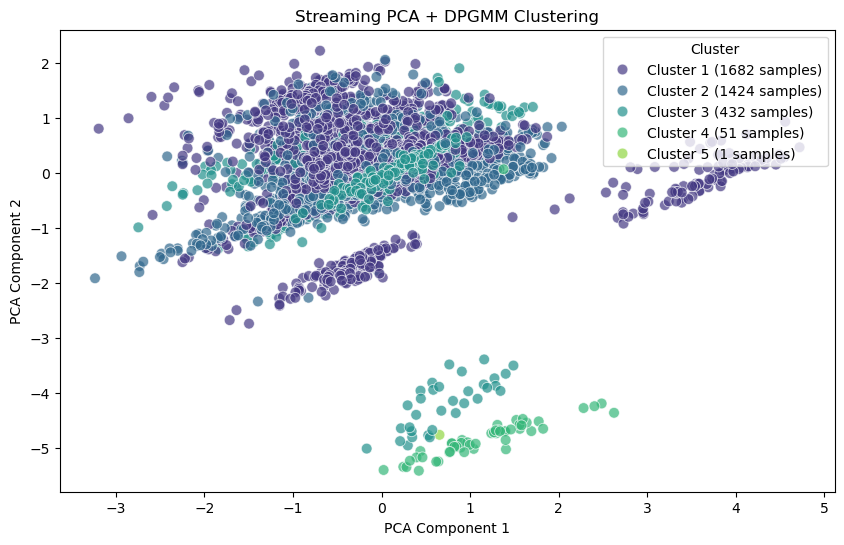

In [25]:
data_with_dpgmm, _ = clustering_models.streaming_dpgmm_clustering(
    normalized_pca_components=normalized_pca_components,
    df=df,
    prior=1,                  # Decides how restrictive the moodel is when creating new clusters the lower the more restrictive
    n_points=1000,            # Number of points to use for the initial clustering
    window_size=400,          # Size of the sliding window
    step_size=100,             # Step size for the sliding window
    max_components=100,       # Maximum number of components to use in the model
    merge_threshold=40,       # Threshold for merging clusters
    merge_within_window=True  # Toggle ON/OFF
)

In [26]:
clustering_visualization.plot_clusters_over_time(data_with_dpgmm, 'DPGMM')

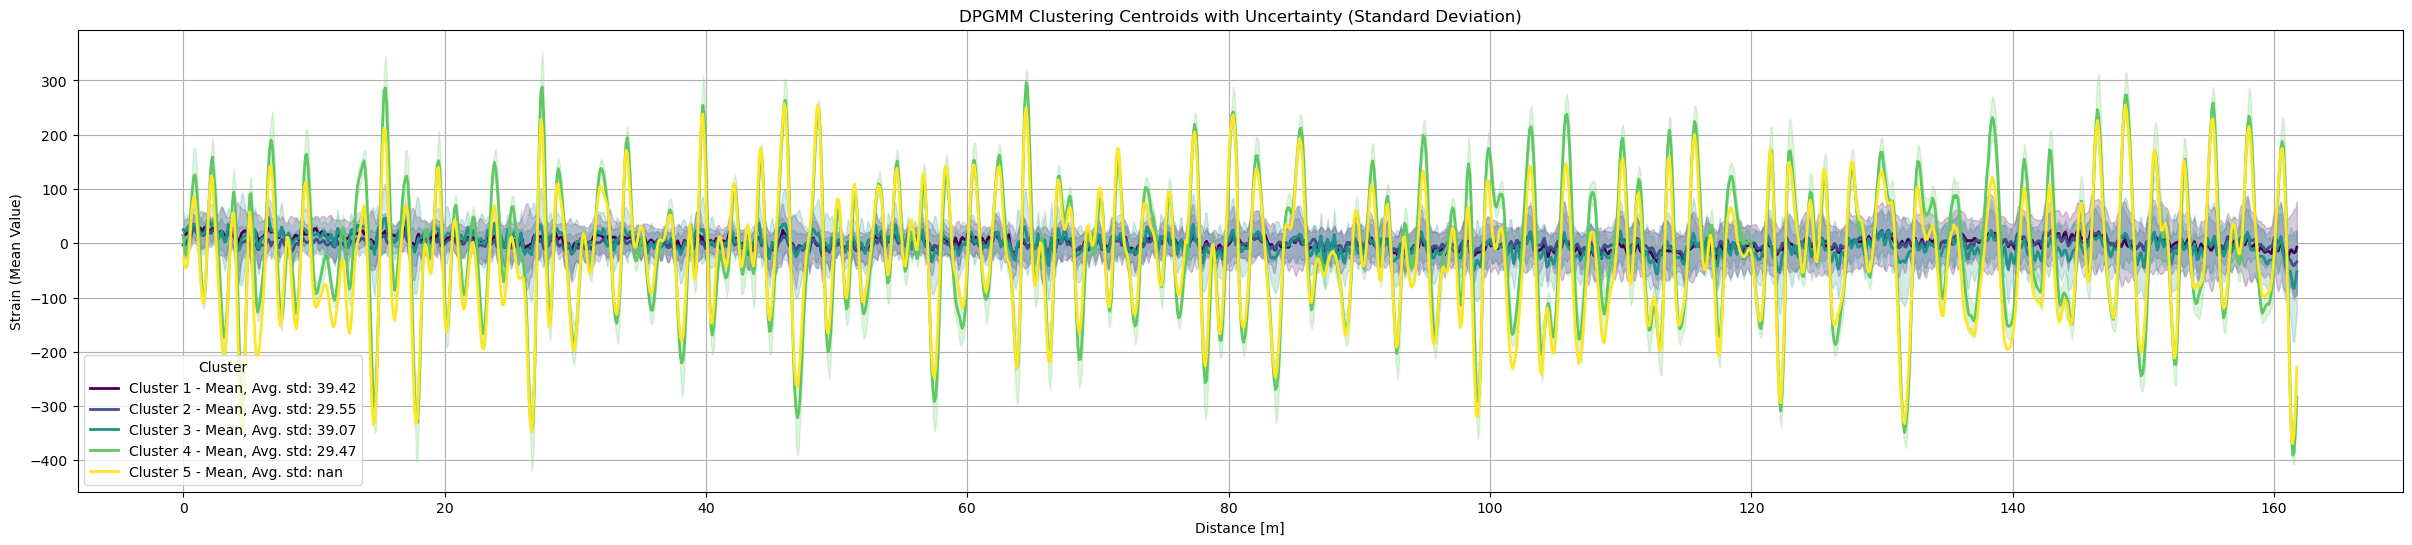

In [27]:
clusters_to_keep = ['all'] # 'all' or a list of cluster indices
clustering_visualization.plot_cluster_mean_and_std(data_with_dpgmm, clusters_to_keep, 'DPGMM')